In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
from torchvision import transforms


from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
preprocess = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data',transform=preprocess,download=True)

Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True,num_workers=0)

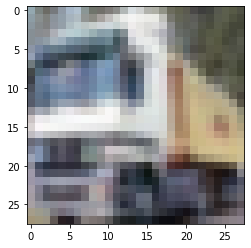

In [5]:
# 資料集繪圖
img = trainset[1][0].permute(1,2,0).numpy()
plt.imshow(img)

In [5]:
def generate_gaussian_noise(latent_dim):
    
    noise = np.random.normal(0, 1, (img.shape[0], latent_dim))
    noise = torch.from_numpy(noise).float().cuda()
    
    return noise

In [6]:
class ConvBNRelu(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(ConvBNRelu,self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(inplace=True)
        )
        
    def forward(self,x):
        tmp = self.conv(x)
        
        return tmp

In [7]:
class Generator_Network(nn.Module):
    
    def __init__(self, latent_dim = 128):
        super(Generator_Network,self).__init__()
        self.latent_dim = latent_dim
        
        self.noise_projection = nn.Sequential(
            nn.Linear(latent_dim,latent_dim*7*7)
        )
        
        self.generator = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvBNRelu(latent_dim,128),
            nn.Upsample(scale_factor=2),
            ConvBNRelu(128,64),
            nn.Conv2d(64,3,3,padding=1),
            nn.Tanh()
        )
        
    def forward(self,x):
        tmp = self.noise_projection(x)
        tmp = tmp.view(-1,self.latent_dim,7,7)
        tmp = self.generator(tmp)
        
        return tmp

In [8]:
class Discriminator_Network(nn.Module):
    
    def __init__(self):
        super(Discriminator_Network,self).__init__()
        self.discriminator = nn.Sequential(
            ConvBNRelu(3,32),
            ConvBNRelu(32,64),
            ConvBNRelu(64,128),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
        self.clf = nn.Sequential(
            nn.Linear(128,1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        tmp = self.discriminator(x)
        tmp = torch.flatten(tmp,start_dim=1)
        tmp = self.clf(tmp)
        return tmp

In [9]:
gen = Generator_Network().cuda()
dis = Discriminator_Network().cuda()

In [10]:
criterion = nn.BCELoss()
optim_G = torch.optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5,0.999))
optim_D = torch.optim.Adam(dis.parameters(),lr=0.0002,betas=(0.5,0.999))

In [11]:
epoches = 10

In [12]:
gen.train()
dis.train()
for e in range(epoches):
    running_loss_G = 0.0
    running_loss_D = 0.0
    for data in tqdm(trainloader):
        img, _ = data
        img = img.cuda()

        valid = torch.ones(img.size(0), 1).cuda()
        fake = torch.zeros(img.size(0), 1).cuda()
        
        noise = generate_gaussian_noise(128)
        
        optim_G.zero_grad()
        gen_img = gen(noise)
        g_loss = criterion(dis(gen_img), valid)
        g_loss.backward()
        optim_G.step()
        running_loss_G+=g_loss.item()

        optim_D.zero_grad()
        real_loss = criterion(dis(img), valid)
        fake_loss = criterion(dis(gen_img.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        running_loss_D+=d_loss.item()
        
    print(f'epoch {e+1}: D:{running_loss_D/len(trainset)} G:{running_loss_G/len(trainset)}')

  0%|▏                                                                                | 3/1563 [00:00<00:58, 26.79it/s]

epoch 1: D:0.020664865721464157 G:0.022830508320331573


  0%|▏                                                                                | 3/1563 [00:00<00:58, 26.79it/s]

epoch 2: D:0.020818689205646515 G:0.022685895985364912


  0%|▏                                                                                | 3/1563 [00:00<00:56, 27.52it/s]

epoch 3: D:0.020738229459524155 G:0.02281797847867012


  0%|▏                                                                                | 3/1563 [00:00<01:04, 24.19it/s]

epoch 4: D:0.02072842903971672 G:0.02283094676733017


  0%|▏                                                                                | 3/1563 [00:00<00:59, 26.32it/s]

epoch 5: D:0.020680926941633225 G:0.022893032646179198


  0%|▏                                                                                | 3/1563 [00:00<00:56, 27.78it/s]

epoch 6: D:0.02063230256795883 G:0.02296418889403343


  0%|▏                                                                                | 3/1563 [00:00<00:56, 27.78it/s]

epoch 7: D:0.02058443162202835 G:0.023035892165899276


  0%|▏                                                                                | 3/1563 [00:00<00:57, 27.03it/s]

epoch 8: D:0.02054223442196846 G:0.023093882319927216


  0%|▏                                                                                | 3/1563 [00:00<01:03, 24.59it/s]

epoch 9: D:0.020534786006212235 G:0.02311459510922432


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.91it/s]

epoch 10: D:0.020545785384178162 G:0.02311374064922333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


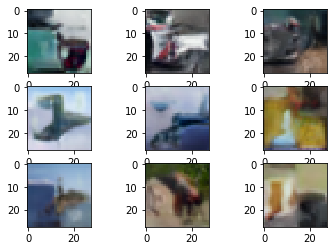

In [13]:
# 合成圖片

for i in range(3):
    for j in range(3):
        with torch.no_grad():
            gen.eval()
            noise = generate_gaussian_noise(128)

            gen_img = gen(noise).detach().cpu()
            gen_img = gen_img[0].permute(1,2,0).numpy()
            
            plt.subplot(3,3,1+i*3+j)
            plt.imshow(gen_img)

In [14]:
torch.save(gen.state_dict(),'gan.pth')